# Проект для «Викишоп»

### Описание задачи

Интернет-магазин «Викишоп» запускает новый сервис.
Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах.
То есть клиенты предлагают свои правки и комментируют изменения других.
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

#### Постановка задачи

Необходимо построить модель классификации, разделяющую комментарии на позитивные и негативные, с целевым значением F1-меры не ниже 0.75

### Описание данных

В нашем распоряжении имеется набор данных с разметкой о токсичности правок.

Столбец «text» — текст комментария, а «toxic» — целевой признак.

## Загрузка библиотек

In [1]:
!pip install nltk

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [2]:
pip install lightgbm

DEPRECATION: Loading egg at /usr/lib64/python3.11/site-packages/TBB-2021.12.0-py3.11-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try
    zypper install python311-xyz, where xyz is the package
    you are trying to install.
    
    If you wish to install a non-rpm packaged Python package,
    create a virtual environment using python3.11 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip.
    
    If you wish to install a non-rpm packaged Python application,
    it may be easiest to use `pipx install xyz`, which will manage a
    virtual environment for you. Install pipx via `zypper install python311-pipx` .

note: If you believe this is a mistake, please contact your Py

In [3]:
# требуется для работы pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tokej/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tokej/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
from lightgbm import LGBMClassifier
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import numpy as np
import re
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [5]:
RANDOM_STATE = 12345

## Загрузка данных

In [6]:
path1 = '/datasets/toxic_comments.csv'
path2 = 'toxic_comments.csv'

if os.path.exists(path1):
    data = pd.read_csv(path1)
elif os.path.exists(path2):
    data = pd.read_csv(path2)
else:
    print('Нет файла с данными')

#### Осмотр данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Видим, что датасет полный, без NaN'ов.
Видим также столбец «Unnamed: 0» неясного назначения: в описании данных его нет.

Посмотрим на первые 5 строк датасета.

In [8]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Датасет загрузился корректно, столбцы соответствуют описанию данных.

Есть, однако, столбец «Unnamed: 0», содержащий неясные числовые данные, и который на вид как будто бы дублирует индексы.
К решению нашей задачи он отношения не имеет, избавимся от него на этапе предобработки данных.

### Предобработка данных

Удалим столбец «Unnamed: 0».

In [9]:
data = data.drop('Unnamed: 0', axis=1)

#### Очистка и лемматизация

Очистим данные от неподходящих символов: спецсимволов, лишних пробелов, символов из нелатинских алфавитов и т.д.

In [10]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.split()
    return ' '.join(text)

data['text'] = data['text'].apply(clear_text)

Посмотрим, сколько у нас строк, целиком состоявших из неподходящих символов (сейчас это пустые строки)

In [11]:
len(data[data['text'] == ''])

11

Немного.
Удалим их.

In [12]:
data = data[data['text'] != '']

Лемматизируем очищенный текст

In [13]:
%%time
def lemmatize_str(text, l):
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        
        return tag_dict.get(tag, wordnet.NOUN)

    return " ".join([l.lemmatize(word, get_wordnet_pos(word)) for word in text.split()])


l = WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: lemmatize_str(x, l))

CPU times: user 3min 11s, sys: 56.5 ms, total: 3min 11s
Wall time: 3min 11s


Проверим получившийся датасет на дубликаты

In [14]:
data.duplicated().sum()

np.int64(1150)

Удалим их.

In [15]:
data = data.drop_duplicates()

Предобработка данных завершена.

### Анализ данных

Посмотрим на баланс классов в нашем датасете

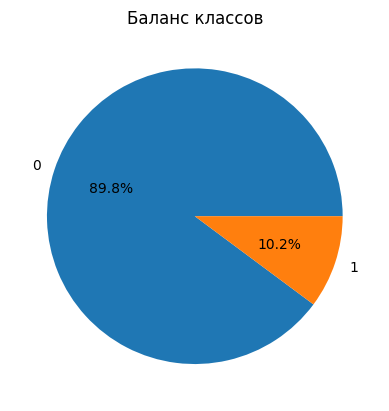

In [16]:
data['toxic'] \
    .value_counts() \
    .plot(kind='pie', ylabel='', title='Баланс классов', autopct='%1.1f%%');

Видим, что наблюдается дисбаланс классов.
Необходимо учитывать его при создании выборок.

### Создание выборок

Создадим выборки, заодно вычислив TF-IDF для нашего корпуса текстов.

In [17]:
X = data.drop(['toxic'], axis=1)
y = data['toxic']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X, 
                                        y, 
                                        test_size=0.25,
                                        stratify=y,
                                        random_state=RANDOM_STATE)

In [19]:
count_tf_idf = TfidfVectorizer(stop_words='english')
X_train = count_tf_idf.fit_transform(X_train['text'].to_list())
X_test = count_tf_idf.transform(X_test['text'].to_list())

Выборки готовы!

### Обучение моделей

#### Логистическая регрессия

Рассмотрим модель логистической регрессии и найдем лучшие гиперпараметры для нее.

In [20]:
model_logr = LogisticRegression()

In [21]:
params = {'C': np.linspace(0.01, 100, 10),
              'fit_intercept': [True, False],
              'random_state': [RANDOM_STATE]}

In [22]:
grid_logr = GridSearchCV(
    model_logr,
    params,
    scoring = 'f1'
)

In [23]:
%%time
grid_logr.fit(X_train, y_train)
print(grid_logr.best_params_)
print(grid_logr.best_score_)

/home/tokej/.local/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'C': np.float64(22.23), 'fit_intercept': True, 'random_state': 12345}
0.7611642124073127
CPU times: user 1h 27min 44s, sys: 964 ms, total: 1h 27min 45s
Wall time: 5min 36s


Мы видим, что нам удалось выйти на целевое значение метрики F1 (не менее 0.75).

### Классификатор LightGBM

Рассмотрим модель LightGBM и найдем лучшие гиперпараметры для нее.

In [24]:
lgbm = LGBMClassifier()

In [25]:
params = {
    'n_estimators': [80, 100, 120],
    'num_leaves': [20, 30, 40],
    'random_state': [RANDOM_STATE]
}

In [26]:
grid_gbm = GridSearchCV(
    lgbm,
    params,
    scoring = 'f1'
)

In [27]:
%%time
grid_gbm.fit(X_train, y_train)
print(grid_gbm.best_params_)
print(grid_gbm.best_score_)

[LightGBM] [Info] Number of positive: 9653, number of negative: 85225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.698011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421673
[LightGBM] [Info] Number of data points in the train set: 94878, number of used features: 8458
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101741 -> initscore=-2.178026
[LightGBM] [Info] Start training from score -2.178026
[LightGBM] [Info] Number of positive: 9653, number of negative: 85225
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.784990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 422130
[LightGBM] [Info] Number of data points in the train set: 94878, number of used features: 8464
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.101741 -> initscore=-2.178026
[LightGBM] [Info] Start training from score -2.178026
[Light

Мы видим, что удалось выйти на целевое значение метрики F1 (0.75), однако полученное значение метрики, тем не менее, хуже таковой у логистической регрессии.

### Решающее дерево

Рассмотрим модель решающего дерева и подберем наилучшие гиперпараметры.

In [28]:
model_dt = DecisionTreeClassifier()

In [29]:
params = {
    'max_depth': [60],
    'min_samples_split': range(2, 4),
    'min_samples_leaf': range(1, 3),
    'random_state': [RANDOM_STATE]
}

In [30]:
grid = GridSearchCV(
    model_dt,
    params,
    scoring = 'f1'
)

In [31]:
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 60, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 12345}
0.7034025001537783


Видим, что показатель метрики не достигает целевого.
Эта модель не подходит.

В целом, наилучший показатель метрики F1 продемострировала модель логистической регрессии.
Выберем ее в качестве лучшей и оценим результат работы на тестовой выборке.

### Качество лучшей модели на тестовой выборке

In [32]:
print(f'Значение F1-метрики лучшей модели — логистической регрессии на тестовой выборке: '
      f'{round(f1_score(y_test, grid_logr.best_estimator_.predict(X_test)), 2)}')

Значение F1-метрики лучшей модели — логистической регрессии на тестовой выборке: 0.77


Целевое значение метрики достигнуто!

## Вывод

Был проведен анализ корпуса текстов и получены следующие результаты.

На этапе предобработки данных был удален посторонний столбец, не имевший отношения к решению нашей задачи.
Также была проведена очистка данных, лемматизация корпуса текстов и проверка данных на полные дубликаты.

Были обучены три модели классификации — логистическая регрессия, LightGBM, решающее дерево — и найдены лучшие значения гиперпарамтеров этих моделей.
Лучшее значение метрики F1 продемонстрировала модель логистической регрессии, которая и была выбрана в качестве лучшей.

Проверка качества на тестовой выборке также продемонстрировала отвечающий условиям задачи результат в смысле целевого значения метрики F1.